In [6]:
!pip install evaluate jiwer

In [7]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy.signal import resample
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader


from transformers import WhisperTokenizer
from transformers import WhisperFeatureExtractor
from transformers import WhisperForConditionalGeneration

In [8]:
import evaluate

wer  = evaluate.load('wer')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [9]:
from datasets import load_dataset

# Define the path to your parquet file
parquet_file_path = '/content/hf_dataset.parquet'

# Load the dataset from the parquet file
hf_dataset_from_parquet = load_dataset('parquet', data_files=parquet_file_path)

# Display the loaded dataset
print(hf_dataset_from_parquet)

DatasetDict({
    train: Dataset({
        features: ['user_id', 'recording_id', 'language', 'duration', 'rec_url_gcp', 'transcription_url_gcp', 'metadata_url_gcp', 'audio_path', 'transcription_path'],
        num_rows: 104
    })
})


# Task
Load the dataset from "/content/hf_dataset.parquet", extract the sampling rates from the audio data, and plot a histogram of the sampling rates.

In [10]:
display(hf_dataset_from_parquet)

DatasetDict({
    train: Dataset({
        features: ['user_id', 'recording_id', 'language', 'duration', 'rec_url_gcp', 'transcription_url_gcp', 'metadata_url_gcp', 'audio_path', 'transcription_path'],
        num_rows: 104
    })
})

In [11]:
print(hf_dataset_from_parquet['train'].features)

{'user_id': Value('int64'), 'recording_id': Value('int64'), 'language': Value('string'), 'duration': Value('int64'), 'rec_url_gcp': Value('string'), 'transcription_url_gcp': Value('string'), 'metadata_url_gcp': Value('string'), 'audio_path': Value('string'), 'transcription_path': Value('string')}


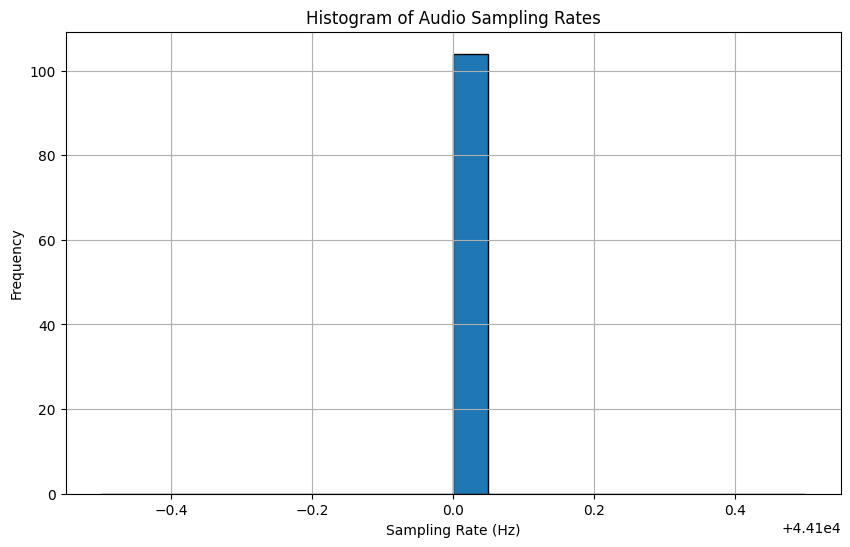

In [12]:
import librosa
import os

sampling_rates = []
# Iterate through each audio path in the dataset
for audio_path in hf_dataset_from_parquet['train']['audio_path']:
    try:
        # Load the audio file and get the sampling rate
        y, sr = librosa.load(audio_path, sr=None)
        sampling_rates.append(sr)
    except Exception as e:
        print(f"Error loading audio from {audio_path}: {e}")
        # Optionally, you can append None or a specific value to indicate failure
        # sampling_rates.append(None)


plt.figure(figsize=(10, 6))
plt.hist(sampling_rates, bins=20, edgecolor='black')
plt.xlabel('Sampling Rate (Hz)')
plt.ylabel('Frequency')
plt.title('Histogram of Audio Sampling Rates')
plt.grid(True)
plt.show()

# What frequencies are present in the dataset

100%|██████████| 104/104 [00:33<00:00,  3.13it/s]


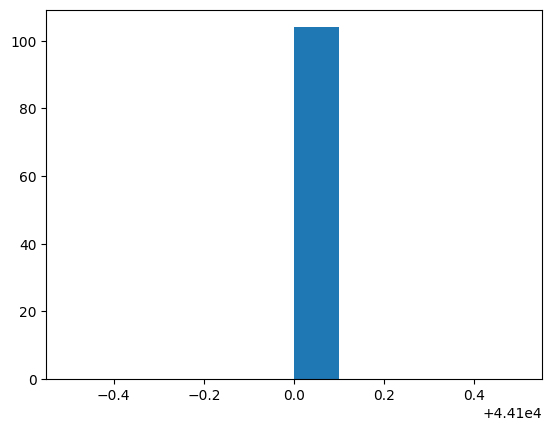

In [13]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import librosa # Import librosa to load audio files

sr_list=[]
for sample in tqdm(hf_dataset_from_parquet['train'],total=len(hf_dataset_from_parquet['train'])):
    # Assuming 'audio_path' is the column containing the path to the audio file
    audio_path = sample['audio_path']
    try:
        # Load the audio file and get the sampling rate
        y, sr = librosa.load(audio_path, sr=None)
        sr_list.append(sr)
    except Exception as e:
        print(f"Error loading audio from {audio_path}: {e}")
        # Optionally, you can append None or a specific value to indicate failure


plt.hist(sr_list)
plt.show()

As there is 32000Hz present in the dataset, we will have to downsample the audio into 16000Hz.

Here's why downsampling is needed in this scenario:

*   **Consistency:** To ensure all audio data is at a uniform sampling rate, which is crucial for many audio processing tasks and for compatibility with models trained on specific sampling rates.
*   **Computational Efficiency:** Processing audio at lower sampling rates requires less computational resources and storage space.
*   **Model Compatibility:** Many pre-trained models for speech recognition or other audio tasks are trained on data sampled at 16000Hz. Downsampling your data to match this allows you to use these models effectively.

By downsampling the 32000Hz audio to 16000Hz, you are reducing the number of samples per second while preserving the relevant information for speech, as the human voice's fundamental frequencies and formants are well within the range captured at 16000Hz.

In [14]:
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small",language='english',task='transcribe')
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small",language='english',task='transcribe')
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
from scipy.signal import resample

def down_sample_audio(audio_original, original_sample_rate):
    target_sample_rate = 16000

    # Calculate the number of samples for the target sample rate
    num_samples = int(len(audio_original) * target_sample_rate / original_sample_rate)

    # Resample the audio array to the target sample rate
    downsampled_audio = resample(audio_original, num_samples)

    return downsampled_audio

In [16]:
import librosa

# Get the path and original sampling rate of the first audio file in the dataset
first_audio_path = hf_dataset_from_parquet['train'][0]['audio_path']
# Load the audio file and get the original sampling rate
audio_original, original_sample_rate = librosa.load(first_audio_path, sr=None)

# Downsample the audio
downsampled_audio = down_sample_audio(audio_original, original_sample_rate)

print(f"Original audio length: {len(audio_original)}")
print(f"Downsampled audio length: {len(downsampled_audio)}")
print(f"Original sampling rate: {original_sample_rate}")
print(f"Target sampling rate: 16000")

Original audio length: 17153509
Downsampled audio length: 6223495
Original sampling rate: 44100
Target sampling rate: 16000


In [17]:
predictions=[]
references=[]

for sample in tqdm(hf_dataset_from_parquet['train'],total=len(hf_dataset_from_parquet['train'])):
    audio_path = sample['audio_path']
    transcription_path = sample['transcription_path']

    try:
        # Load the audio file
        audio, sample_rate = librosa.load(audio_path, sr=None)

        # Downsample the audio if necessary
        if sample_rate != 16000:
            audio = down_sample_audio(audio, sample_rate)
            sample_rate = 16000 # Update sample_rate after downsampling


        # Load the transcription
        with open(transcription_path, 'r') as f:
            text = f.read().strip()


        input_features = feature_extractor(
        raw_speech=audio,
        sampling_rate=sample_rate, # Use the actual or downsampled sample rate
        return_tensors='pt',
        padding=True).input_features

        # Generate predictions with no gradient computation
        with torch.no_grad():
            op = model.generate(input_features.to('cuda'), language='english', task='transcribe')

        # Decode predictions
        text_preds = tokenizer.batch_decode(op, skip_special_tokens=True)

        # Append batch predictions and references to the respective lists
        predictions.extend(text_preds)
        references.extend([text])

    except Exception as e:
        print(f"Error processing sample from {audio_path}: {e}")

    # break # Uncomment this line to test with a single sample

 12%|█▏        | 12/104 [02:11<16:51, 11.00s/it]


KeyboardInterrupt: 

In [18]:
print(f"Length of predictions: {len(predictions)}")
print(f"Length of references: {len(references)}")

Length of predictions: 12
Length of references: 12


In [19]:
wer_score = wer.compute(predictions=predictions, references=references) * 100
print(f"Word Error Rate (WER): {wer_score:.2f}%")

Word Error Rate (WER): 100.00%


In [20]:
text

'[\n  {\n    "start": 0.13,\n    "end": 15.07,\n    "speaker_id": 198074,\n    "text": "जी जी जी इतिहास रच दिए हम जहां रहते है ऐतिहासिक स्थल है अभी हम नालंदा में थे नालंदा खंडार भी गए है हा नालंदा खंडार गए भी है नालंदा विश्व विद्यालय जो पहले था राजगीर ।"\n  },\n  {\n    "start": 15.79,\n    "end": 30.01,\n    "speaker_id": 198074,\n    "text": "उन्हों से क्या घुरें पहले से तो भाई बहुत अच्छा बन गया है लेकिन हां वो जगह बहुत ही पुराने पुराने दीवार इतना मोटा मोटा दीवार पहली बार देखे थे नंदा खंडहर का बहुत ही"\n  },\n  {\n    "start": 30.22,\n    "end": 45.1,\n    "speaker_id": 198074,\n    "text": "खंडर बन गया लेकिन फिर भी बहुत सुन्दर अभी भी है बहुत अच्छा ऐतिहासिक जगह उसका डिजाइन एक से एक डिजाइन उसका ईट का डिजाइन इतना बढ़िया बढ़िया सजाया गया है ईंट की हम देख नहीं सकते देख के कहेंगे की बहुत पुराना बहुत अच्छा है"\n  },\n  {\n    "start": 45.43,\n    "end": 60.25,\n    "speaker_id": 198074,\n    "text": "पीठ हो या वहां का स्थल हो कितना दरवाजा था जितना अभी भी किला जना रहा है बहुत अच्छा उसका शाय

In [21]:
text_preds

[' Yes, this is the history of this place. We live in this place, where we are now in Nalanda. Nalanda is the place of Khandhar. Yes, Nalanda is the place of Khandhar. Nalanda is the place of the first king, of both the places. The first one was very good. But, there was a lot of old walls, such big walls, we saw for the first time.']